# Маркетинговый анализ приложения Procrastinate Pro+
Период для анализа - с 1 мая по 27 октября 2019 года.

В проекте проанализируем рекламную кампанию развлекательного приложения Procrastinate Pro+. Выявим проблемные каналы привлечения пользователей, страны и устройства и дадим некоторые рекомендации по улучшению.

Для этого:
- проведем предобработку данных;
- посчитаем  отобразим на графиках "пожизненную ценность пользователя" (LTV), "стоимость привлечения пользователя" (CAC) и окупаемость рекламы (ROI);
- также рассмотрим графики конверсии и удержания пользователей.

## Загрузка и подготовка данных
Загрузим данные о визитах, заказах и расходах. Проведем их предобработку для дальнейшего анализа.

In [1]:
#импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

Посмотрим на таблицу c посещениями

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
visits.duplicated().sum()

0

- пропусков нет;
- дубликатов нет;
- названия столбцов приведем к "змеиному" регистру;
- тип данных в столбцах Session Start и Session End изменим на datetime.

In [6]:
#функция для приведения столбцов к змеиному регистру
def columns_renaming(data):
  cols = list(data.columns)
  for col in cols:
      data = data.rename(columns={col: col.lower().replace(' ', '_')})
  return data

visits = columns_renaming(visits)

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%Y%m%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%Y%m%d %H:%M:%S')

Посмотрим на таблицу c заказами

In [8]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
orders.duplicated().sum()

0

- пропусков нет;
- дубликатов нет;
- названия столбцов приведем к "змеиному" регистру;
- тип данных в столбцe Event Dt изменим на datetime.

In [11]:
orders = columns_renaming(orders) 
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y%m%d %H:%M:%S')

Посмотрим на таблицу c затратами на маркетинг

In [12]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [14]:
costs.duplicated().sum()

0

- пропусков нет;
- дубликатов нет;
- названия столбцов приведем к "змеиному" регистру;
- тип данных в столбцe dt изменим на datetime.

In [15]:
costs = columns_renaming(costs) 
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Воспользуемся функциями, изученными в теоретической части:

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Получим профили пользователей

In [24]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Максимальная и минимальная даты привлечения пользователей

In [25]:
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
print('Минимальная дата привлечения - {}'.format(min_date))
print('Максимальная дата привлечения - {}'.format(max_date))

Минимальная дата привлечения - 2019-05-01 00:00:41
Максимальная дата привлечения - 2019-10-27 23:59:04


Посмотрим, из каких стран чаще всего приходят пользователи 

In [26]:
t = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'})\
.rename(columns={'user_id': 'total_users', 'payer': 'payers'})\
.sort_values(by='total_users', ascending=False)\
.reset_index()
t['payers / users'] = t['payers'] / t['total_users']
t

,region,total_users,payers,payers / users
0,United States,100002,6902,0.069019
1,UK,17575,700,0.039829
2,France,17450,663,0.037994
3,Germany,14981,616,0.041119


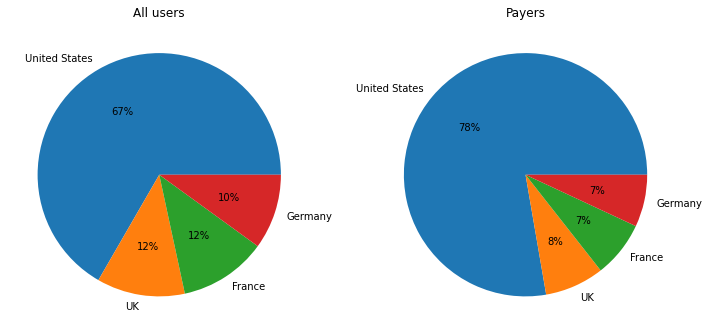

In [27]:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.pie(t['total_users'], labels=t['region'], autopct='%1.0f%%')
plt.title('All users')

plt.subplot(1, 2, 2)
plt.pie(t['payers'], labels=t['region'], autopct='%1.0f%%')
plt.title('Payers')
plt.tight_layout()
plt.show();   

В нашей выборке пользователи всего из 4 стран: США, Англия, Франция и Германия.

Больше всего пользователей нашего приложения - в США. Причем в разы: в США пользователей более чем в 2 раза больше, чем суммарно в Англии, Германии и Франции.

По покупателям - США тоже однозначный лидер.

Стоит отметить, что соотношение покупателей к пользователям внутри стран также лучшее в США.

Посмотрим, какими устройствами чаще всего пользуются.

In [28]:
t = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})\
.rename(columns={'user_id': 'total_users', 'payer': 'payers'})\
.sort_values(by='total_users', ascending=False)\
.reset_index()
t['payers / users'] = t['payers'] / t['total_users']
t

,device,total_users,payers,payers / users
0,iPhone,54479,3382,0.062079
1,Android,35032,2050,0.058518
2,PC,30455,1537,0.050468
3,Mac,30042,1912,0.063644


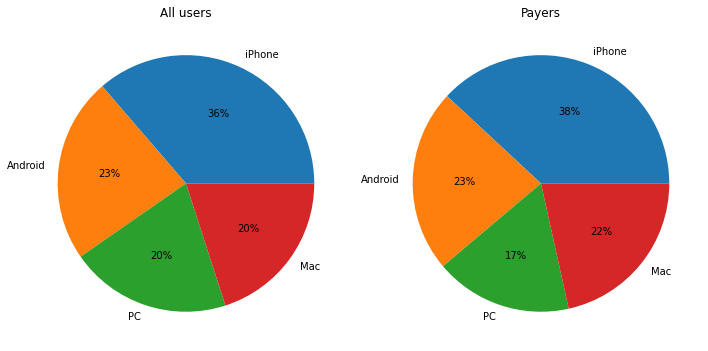

In [29]:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.pie(t['total_users'], labels=t['device'], autopct='%1.0f%%')
plt.title('All users')

plt.subplot(1, 2, 2)
plt.pie(t['payers'], labels=t['device'], autopct='%1.0f%%')
plt.title('Payers')
plt.tight_layout()
plt.show(); 

Больше всего пользователи заходят в приложение с iPhone, сильно реже с Android. Третье место делят - PC и Mac.

Аналогично распределяются по устройствам и покупатели.

Пользователи с iPhone чаще других делают покупки.

Платящих пользователей с Mac всего на 138 меньше, чем с Android.

Реже всего соверщают покупки в приложении пользователи с PC.

Отметим, что по соотношению покупателей ко всем пользователям значительно ниже только группа пользователей с PC. Группы пользователей с iPhone, Mac и Andoid примерно на одном уровне по этому показателю.

Посмотрим, какие рекламные каналы были использованы для привлечения пользователей:

In [30]:
t = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})\
.rename(columns={'user_id': 'total_users', 'payer': 'payers'})\
.sort_values(by='total_users', ascending=False)\
.reset_index()
t['payers / users'] = t['payers'] / t['total_users']
t

,channel,total_users,payers,payers / users
0,organic,56439,1160,0.020553
1,FaceBoom,29144,3557,0.122049
2,TipTop,19561,1878,0.096007
3,OppleCreativeMedia,8605,233,0.027077
4,LeapBob,8553,262,0.030633
5,WahooNetBanner,8553,453,0.052964
6,RocketSuperAds,4448,352,0.079137
7,MediaTornado,4364,156,0.035747
8,YRabbit,4312,165,0.038265
9,AdNonSense,3880,440,0.113402


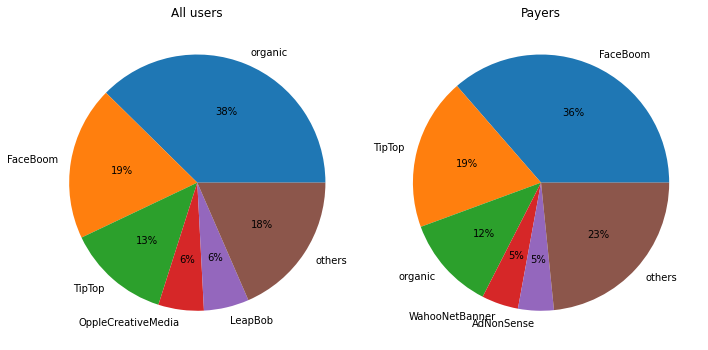

In [31]:
t1 = t.head()\
.append({'channel': 'others', 
        'total_users': t.loc[5:, 'total_users'].sum(),
        'payers': t.loc[5:, 'payers'].sum(),
        'payers / users': t.loc[5:, 'payers / users'].sum() 
        }, ignore_index=True)

t = t.sort_values(by='payers', ascending=False)
t = t.head()\
.append({'channel': 'others', 
        'total_users': t.loc[5:, 'total_users'].sum(),
        'payers': t.loc[5:, 'payers'].sum(),
        'payers / users': t.loc[5:, 'payers / users'].sum() 
        }, ignore_index=True)

fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.pie(t1['total_users'], labels=t1['channel'], autopct='%1.0f%%')
plt.title('All users')

plt.subplot(1, 2, 2)
plt.pie(t['payers'], labels=t['channel'], autopct='%1.0f%%')
plt.title('Payers')
plt.tight_layout()
plt.show(); 

37.6% пользователей заинтересовались приложением самостоятельно.

Лидеры среди рекламных каналов:
- FaceBoom - 19,4%;
- TipTop - 13%.

Интересный момент: больше всего покупателей пришло через рекламный канал FaceBoom (36%), который был лидером среди рекламных каналов  по общему количеству пользователей, но сильно уступал группе organic (пользователи, скачавшие приложение самостоятельно, без переходов по рекламным ссылкам).

Organic по платящим пользователям только на третьем месте.

На втором месте по платящим пользователям канал TipTop.

Стоит отметить канал привлечения AdNonSense - по всем привлеченным пользователям он только на 10 месте, а по платящим - уже на 5-ом. Это может говорить о том, что через него привлекаются одни из самых "качественных" пользователей.

*Выводы:*
- 67% всех пользователей из США. При этом доля покупателей из США еще выше - 78%;
- Чаще всего пользователи приложения используют iPhone. На втором месте - Android. Третье место делят - PC и Mac. Распределение по покупателям такое же;
- 38% пользователей - пришли в приложение самостоятельно. Каналы-лидеры по количеству привлеченных пользователей и покупателей - FaceBoom и TipTop.

## Маркетинговый анализ

Посмотрим, сколько всего денег потратили на маркетинг

In [32]:
costs['costs'].sum()

105497.30000000002

Посмотрим, как распределился рекламный бюджет по источникам привлечения

In [33]:
t = costs.groupby('channel')\
.agg({'costs': 'sum'})\
.rename(columns={'costs': 'total_cost'})\
.sort_values(by='total_cost', ascending=False)\
.reset_index()
t['pct'] = t['total_cost'] / t['total_cost'].sum()
t

,channel,total_cost,pct
0,TipTop,54751.30,0.518983
1,FaceBoom,32445.60,0.307549
2,WahooNetBanner,5151.00,0.048826
3,AdNonSense,3911.25,0.037074
4,OppleCreativeMedia,2151.25,0.020392
5,RocketSuperAds,1833.00,0.017375
6,LeapBob,1797.60,0.017039
7,lambdaMediaAds,1557.60,0.014764
8,MediaTornado,954.48,0.009047
9,YRabbit,944.22,0.008950


Выделяются каналы: TipTop и FaceBoom. На них приходится 82,6% всех потраченных денег.

Посмотрим, как менялись расходы в каналах по месяцам

In [34]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

t = costs.groupby(['channel', 'month']).agg({'costs': 'sum'}).reset_index()
t

,channel,month,costs
0,AdNonSense,5,1169.700
1,AdNonSense,6,538.650
2,AdNonSense,7,504.000
3,AdNonSense,8,579.600
4,AdNonSense,9,581.700
5,AdNonSense,10,537.600
6,FaceBoom,5,3524.400
7,FaceBoom,6,5501.100
8,FaceBoom,7,5294.300
9,FaceBoom,8,6274.400


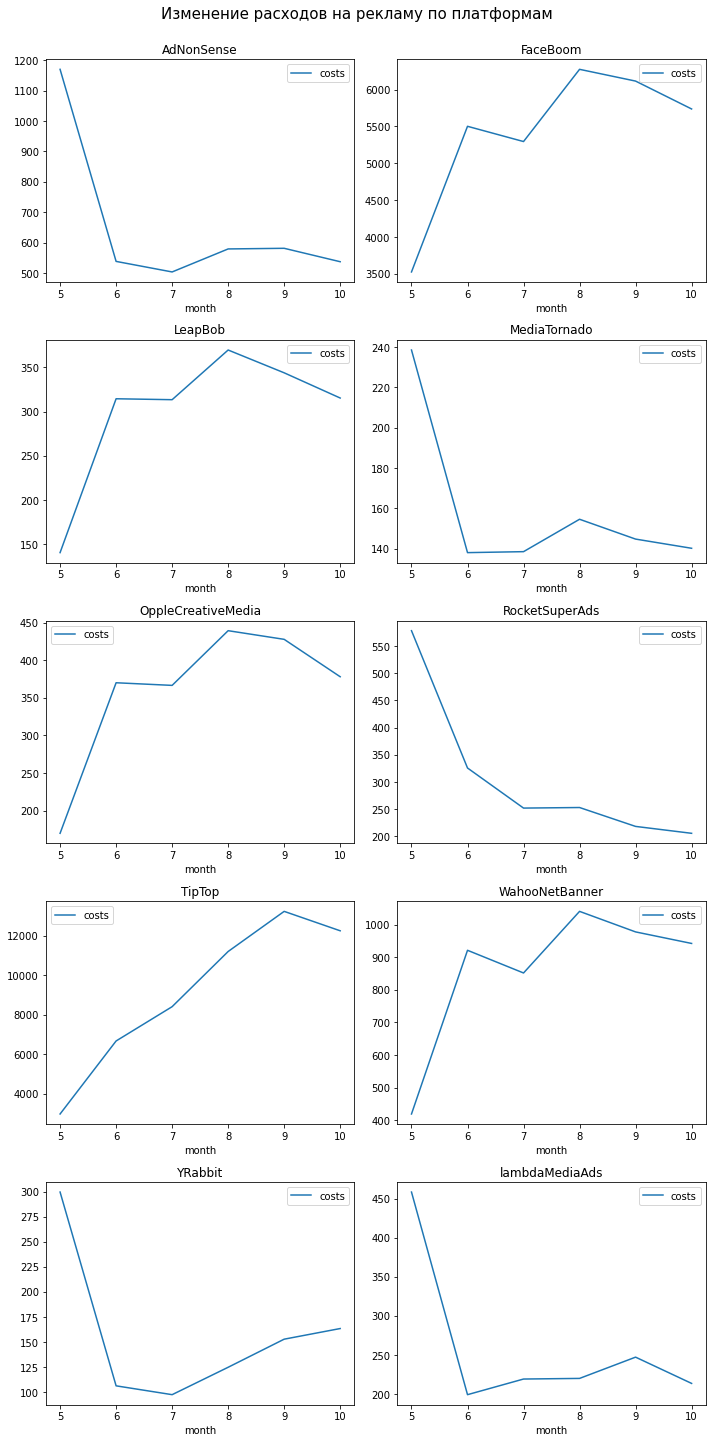

In [35]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

t = costs.groupby(['channel', 'month']).agg({'costs': 'sum'}).reset_index()

fig = plt.figure(figsize=(10,20))
fig.suptitle('Изменение расходов на рекламу по платформам', fontsize = 15, y=1)

for i, channel in enumerate(t['channel'].unique()):
    t[t['channel'] == channel].plot(x='month', y='costs', ax=plt.subplot(5, 2, i+1))
    plt.title(channel)
    plt.tight_layout()

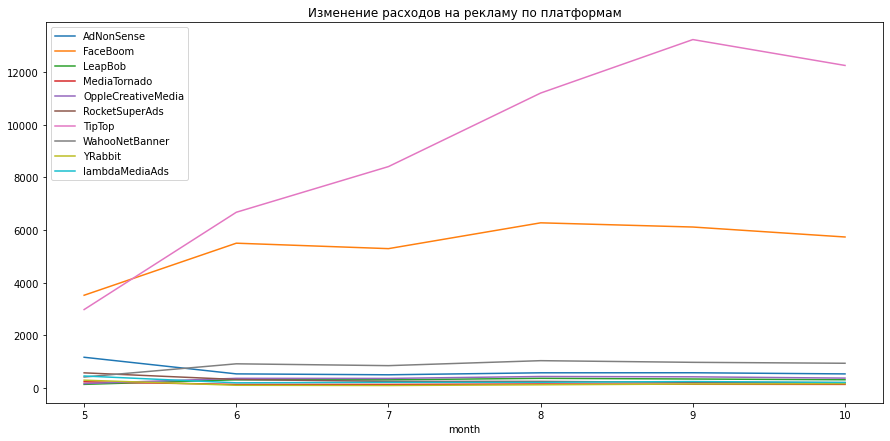

In [36]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

t = costs.groupby(['channel', 'month']).agg({'costs': 'sum'}).reset_index()

for i, channel in enumerate(t['channel'].unique()):
    if i == 0:
        ax = t[t['channel'] == channel].plot(x='month', y='costs', label=channel, figsize=(15,7))
    else:
        t[t['channel'] == channel].plot(x='month', y='costs', label=channel, ax=ax)
plt.title('Изменение расходов на рекламу по платформам')
plt.legend(loc='best')
plt.show();

Посчитаем среднюю стоимость привлечения одного пользователя

In [37]:
print(profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean())
print(profiles[profiles['channel'] != 'organic']['acquisition_cost'].median())

1.127481323942928
1.0805309734513273


Средняя арифметическая стоимость привлечения одного клиента не сильно отличается тот медианной стоимости. 

Посмотрим, сколько в среднем стоило привлечение одного пользователя в каждом источнике:

In [38]:
t = profiles\
.groupby('channel')\
.agg({'acquisition_cost': ['mean', 'median'], 'user_id': 'count'})
t.columns = t.columns.map('_'.join)
t.rename(columns={'channel_': 'channel'}).sort_values(by='acquisition_cost_mean', ascending=False).reset_index()

,channel,acquisition_cost_mean,acquisition_cost_median,user_id_count
0,TipTop,2.799003,3.000000,19561
1,FaceBoom,1.113286,1.114667,29144
2,AdNonSense,1.008054,1.004348,3880
3,lambdaMediaAds,0.724802,0.733333,2149
4,WahooNetBanner,0.602245,0.600000,8553
5,RocketSuperAds,0.412095,0.404444,4448
6,OppleCreativeMedia,0.250000,0.250000,8605
7,YRabbit,0.218975,0.214286,4312
8,MediaTornado,0.218717,0.220926,4364
9,LeapBob,0.210172,0.210000,8553


*Выводы:*
- расходы на рекламы в TipTop и FaceBoom в несколько раз превышают расходы на остальные каналы;
- по платформам AdNonSense, MediaTornado, RocketSuperAds, YRabbit и lambdaMediaAds наблюдается достаточно резкое снижение расходов в июне. Возможно, в мае проводилась какая-то масштабная рекламная кампания на этих платформах;
- по платформам FaceBoom, LeapBob, OppleCreativeMedia и WahooNetBanner, наоборот, наблюдался рост расходов на рекламу в июне. Возможно, после проведения предполагаемой масштабной акции в мае на платформах из первого пункта, произошло перерапределение рекламного бюджета по остальным платформам;
- по платформе AdNonSense с июня по октябрь расходы на рекламу держались стабильно;
- по платформам FaceBoom, LeapBob, MediaTornado, OppleCreativeMedia и WahooNetBanner наблюдался рост расходов на рекламу в августе - возможно, это была еще одна специальная акция, но по большему количеству платформ;
- по платформе RocketSuperAds расходы на рекламу с мая по октябрь стабильно снижались;
- стоит обратить внимание на платформы: **TipTop** и **YRabbit**. Расходы на рекламу в TipTop с мая по сентябрь каждый месяц увеличивались, немного снизившись в октябре. Расходы на рекламу в YRabbit сильно снизились в июне-июле после предполагаемой масштабной рекламной акции, но затем, в августе-октябре, перманентно росли;
- наибольшая средняя стоимость привлечения одного клиента в платформах TipTop, FaceBoom и AdNonSense;
- наименьшая средняя стоимость привлечения одного клиента в платформах LeapBob, MediaTornado и YRabbit;
- при этом количество пользователей, привлеченных через TipTop и FaceBoom, в разы превышает количество пользователей из LeapBob, MediaTornado и YRabbit;
- средняя стоимость привлечения одного пользователя по всем платформам равна 1,1.

## Оценка окупаемости рекламы для привлечения пользователей

Установим момент анализа данных - 1 ноября 2019 года. Ппредполагаемый срок окупаемости рекламы 2 недели - установим горизонт анализа данных 14 дней.

In [39]:
observation_date = datetime(2019, 11, 1).date() 
horizon = 14

Для органических пользователей CAC равен 0. Следовательно, ROI будет стремиться к бесконечности при любых значениях LTV. Поэтому разумно будет для дальнейшего анализа эти показателей исключить из нашей выборки органических пользователей.

In [40]:
profiles = profiles[profiles['channel'] != 'organic']

Рассчитаем LTV, CAC и ROI для всего проекта и построим их графики: 

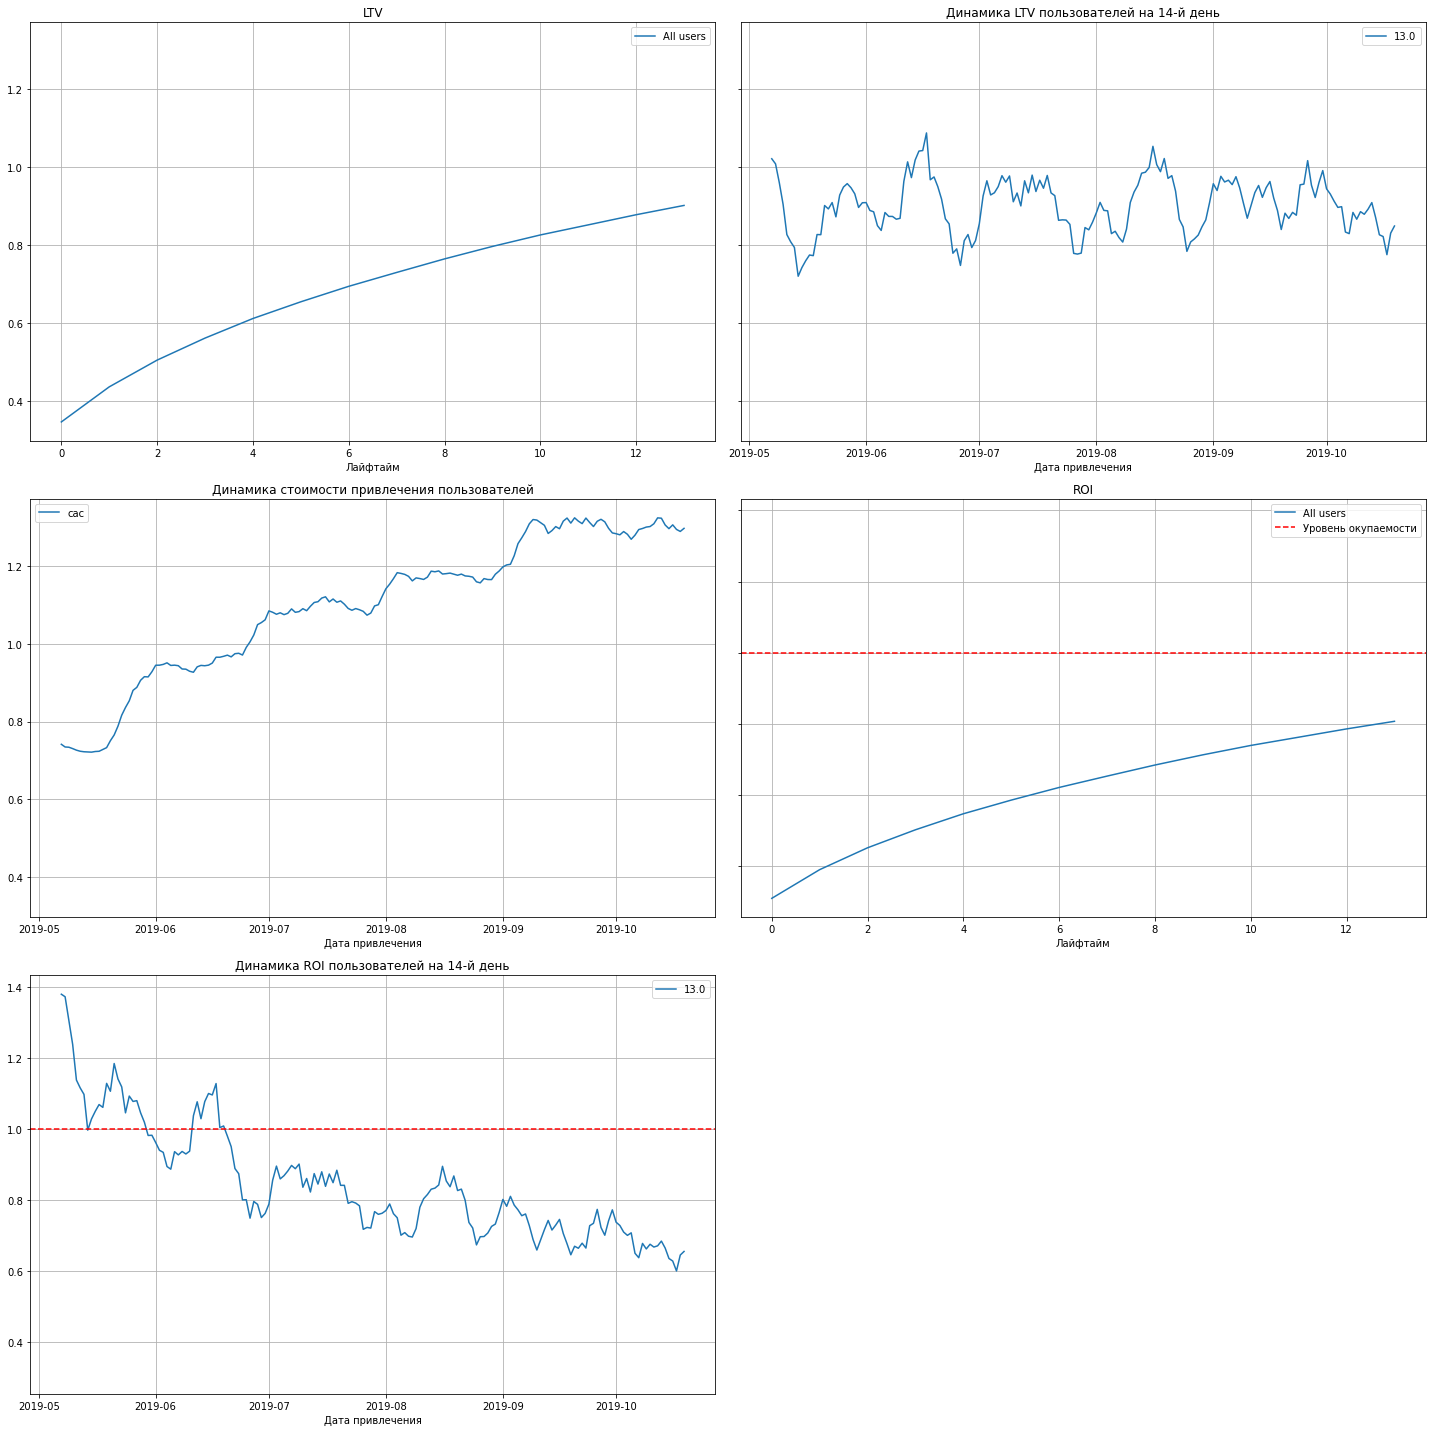

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

По полученным данным можно сделать следующие выводы:
- наиболее прибыльными с точки зрения LTV на 14 день были когорты пользователей, привлеченных в июне и августе;
- реклама не окупается - на 14 день лайфтайма ROI едва превышает 80%;
- очевидна проблема с CAC - стоимость привлечения одного пользователя с мая по октябрь увеличилась примерно в 1,5 раза;
- судя по графику динами ROI, реклама перестала стабильно окупаться с когорты пользователей, привлеченных в середине июня. 

Посмотрим, как ведут себя эти показатели, если сделать разбивку по рекламным каналам:

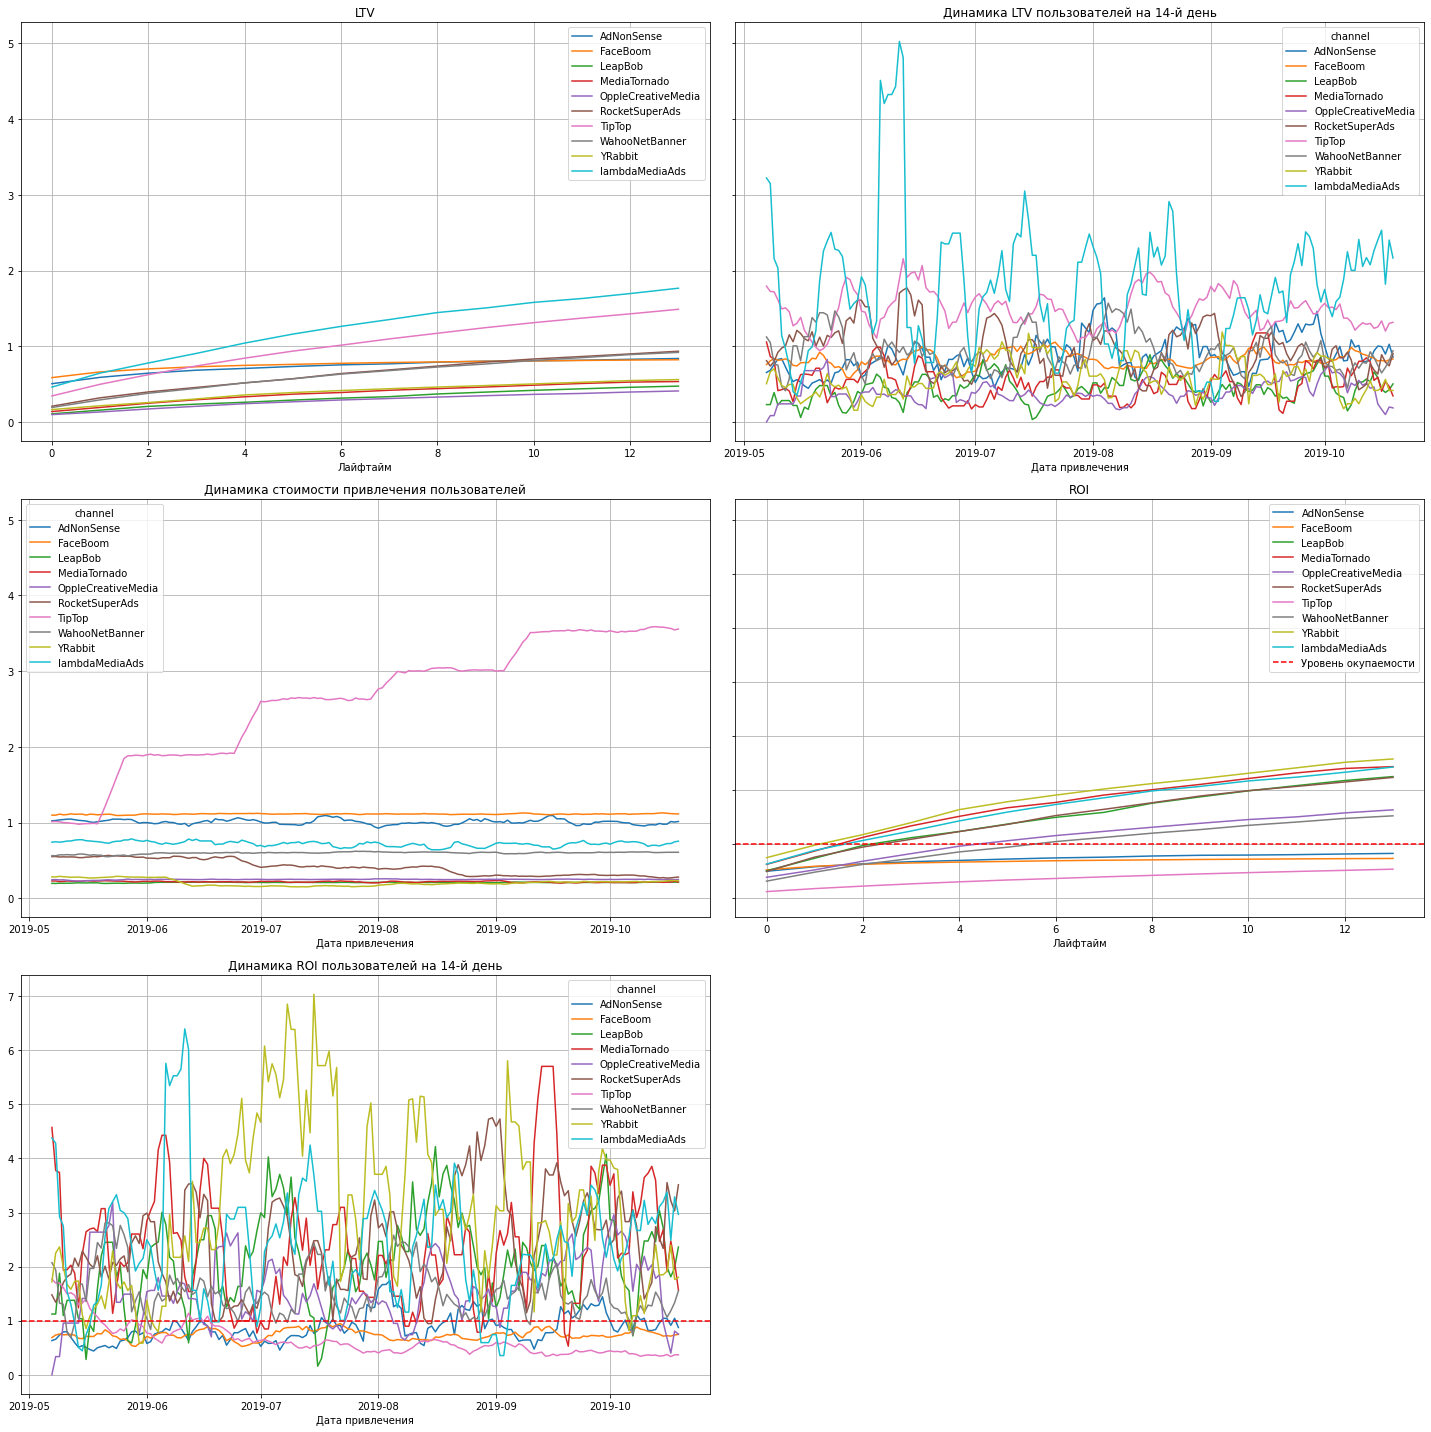

In [42]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon, dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

По графикам можно сказать:
- средняя стоимость привлечения одного клиента держится стабильно по всем каналам, кроме TipTop. В TipTop она ежемесячно увеличивается - это надо исправлять;
- пользователи привлеченные через каналы AdNonSense, FaceBoom и TipTop за двухнедельных лайфтайм не окупаются;
- почти ни одна когорта пользователей, привлеченных через FaceBoom и TipTop c мая по октябрь, не окупилась;
- когорты пользователей, привлеченных через AdNonSense c мая по октябрь, находятся на границе окупаемости;
- быстрее всех окупились пользователи, привлеченные через каналы lambdaMediaAds, YRabbit и MediaTornado.

Посмотрим, как ведут себя эти показатели, если сделать разбивку по странам:

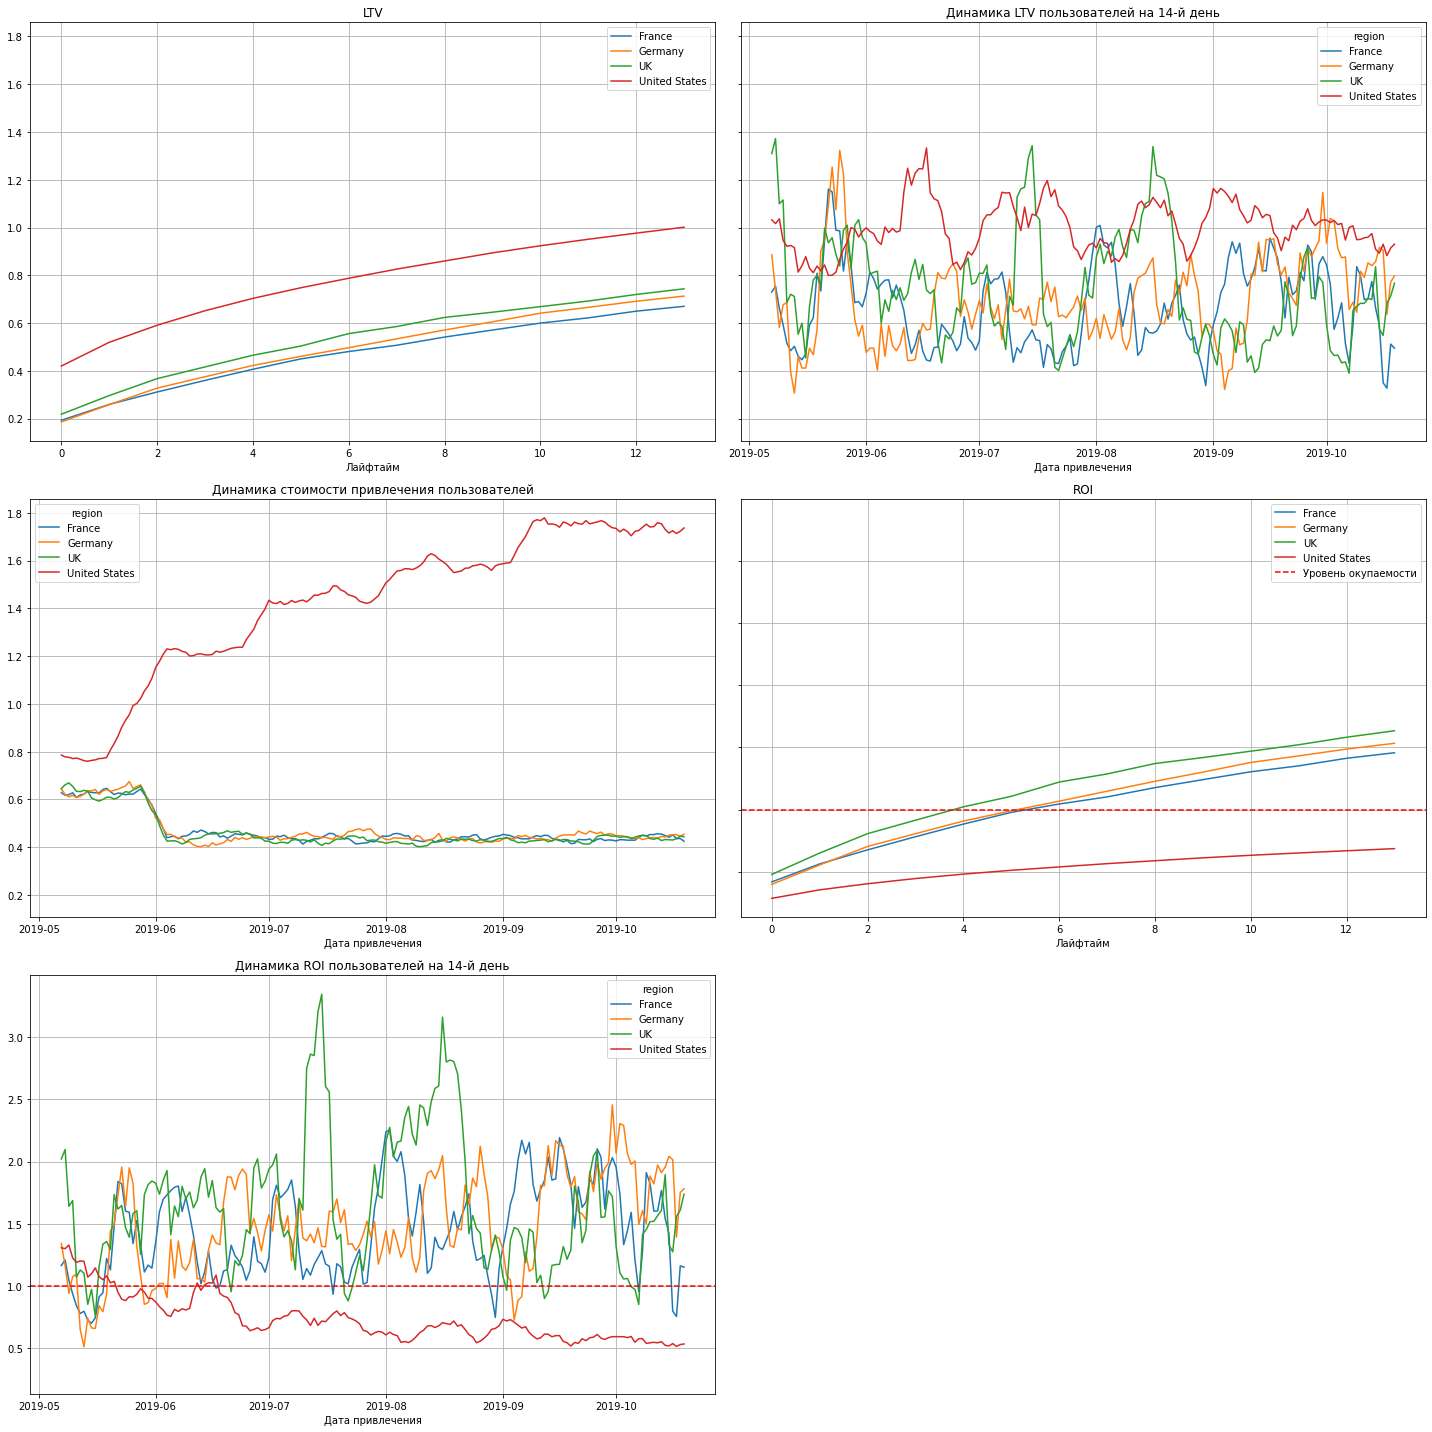

In [43]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon, dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

*Выводы:*
- реклама окупается за первую неделю во всех странах, кроме США. Там она не окупается даже за две недели;
- в США средняя стоимость привлечения одного пользователей постоянно растет - это может быть главной причиной неокупаемости;
- в остальных странах средняя стоимость привлечения пользователей снижается в июне и далее держится стабильно;
- в США частично окупались когорты пользователей привлеченных только в мае.

Сделаем разбивку по устройствам и ещё раз посмотрим на графики показателей:

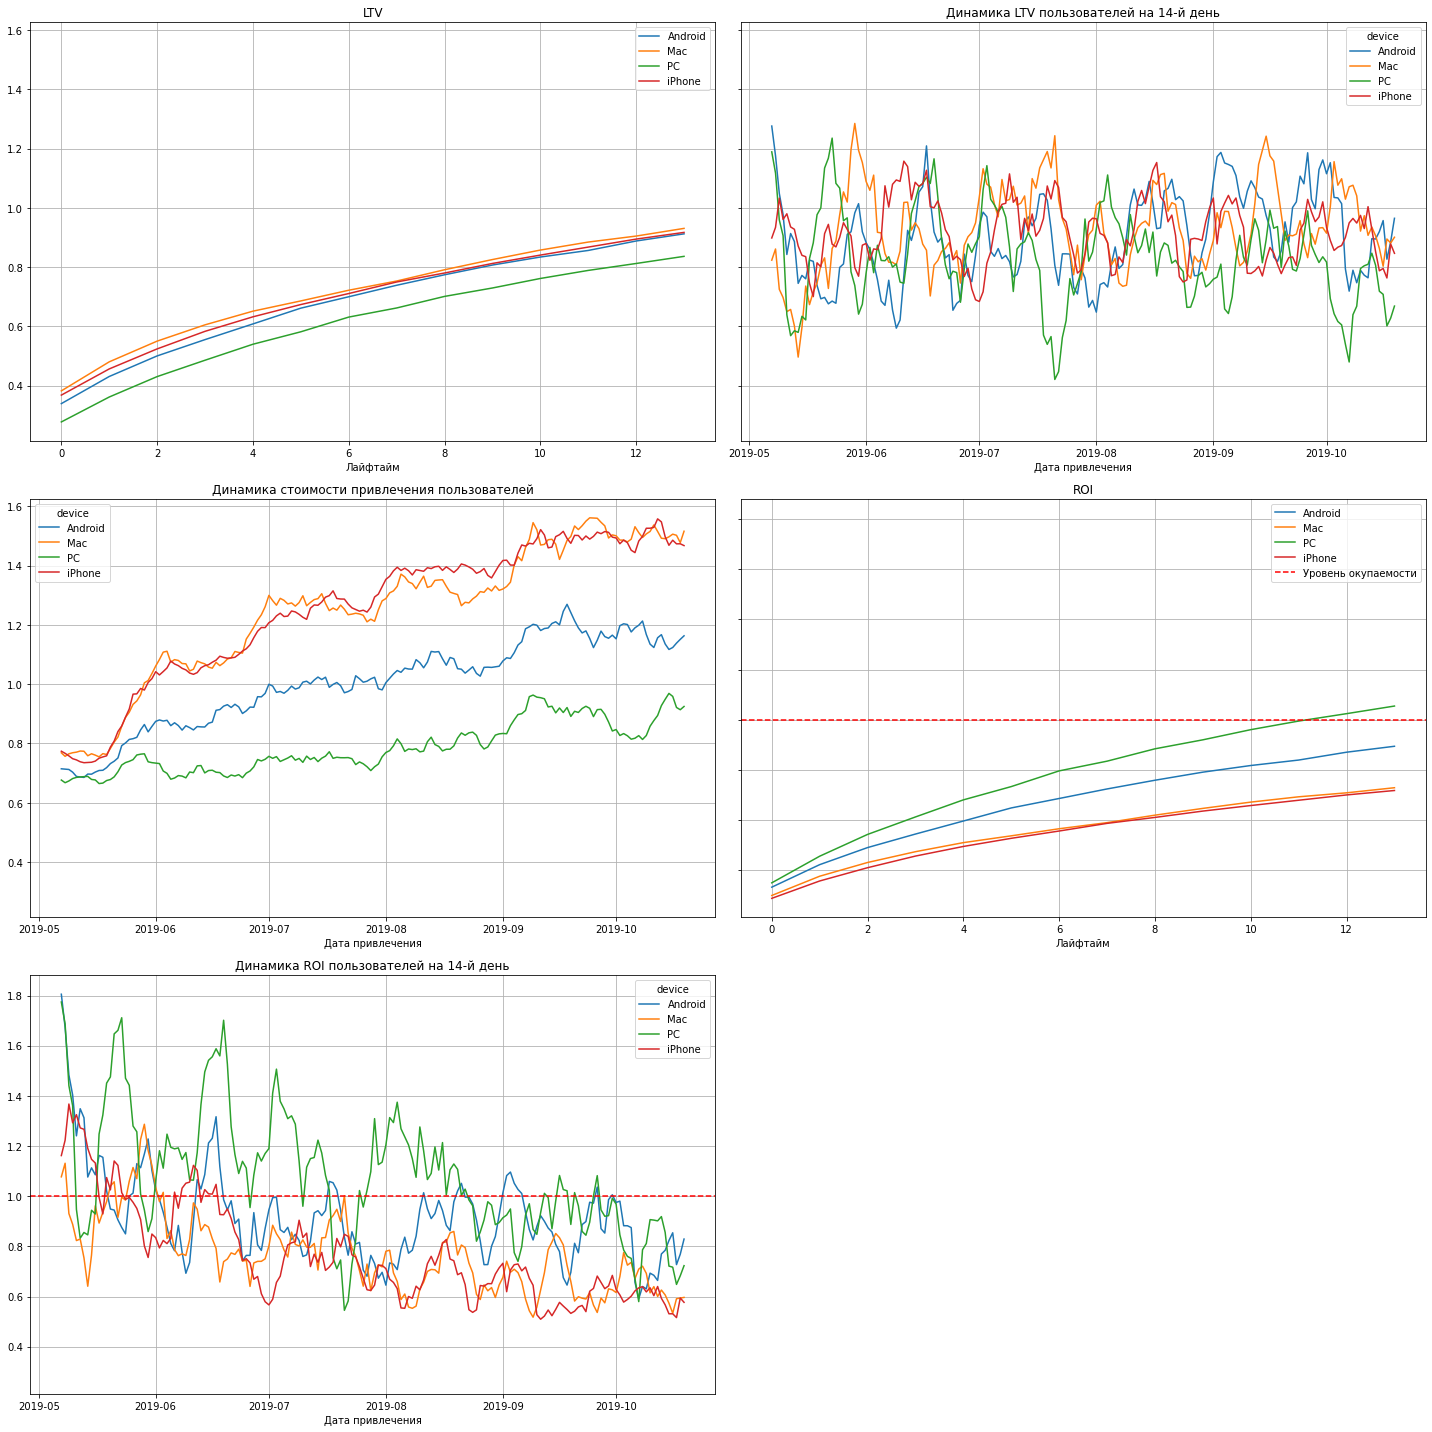

In [44]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon, dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

*Выводы:*
- быстрее всех стоимость привлечения растет у пользователей с Mac и iPhone;
- медленнее растет стоимость привлечения пользователей с Android;
- наиболее стабильно держится стоимость привлечения пользователей с PC, но и по этой когорте наблюдается рост стоимости привлечения в августе и сентябре;
- реклама окупается только для пользователей с PC.

**Общие выводы по анализу LTV, CAC и ROI:**

1. В целом реклама не окупается - на 14 день лайфтайма ROI едва превышает 80%:
- пользователи привлеченные через каналы AdNonSense, FaceBoom и TipTop за двухнедельных лайфтайм не окупились;
- быстрее всех окупились lambdaMediaAds, YRabbit и MediaTornado;
- реклама окупается за первую неделю во всех странах, кроме США. Там она не окупается даже за две недели;
- реклама окупается только для пользователей с PC.

2. Есть проблема - стоимость привлечения одного пользователя с мая по октябрь увеличилась примерно в 1,5 раза;
- основной вклад в увеличение стоимости привлечения делает рекламный канал TipTop, по остальным каналам стоимость привлечения стабильна;
- в США стоимость привлечения постоянно растет, в остальных странах - держится стабильно;
- быстрее всех стоимость привлечения растет у пользователей с Mac и iPhone. Растет, но медленнее стоимость привлечения пользователей с Android.

## Анализ конверсии и удержания

Посмотрим, как пользователи конвертировались в покупателей и как хорошо они удерживались. Начнем с разбивки по каналам привлечения.

На этом этапе для полной картины вернем профили органических пользователей в нашу выборку. 

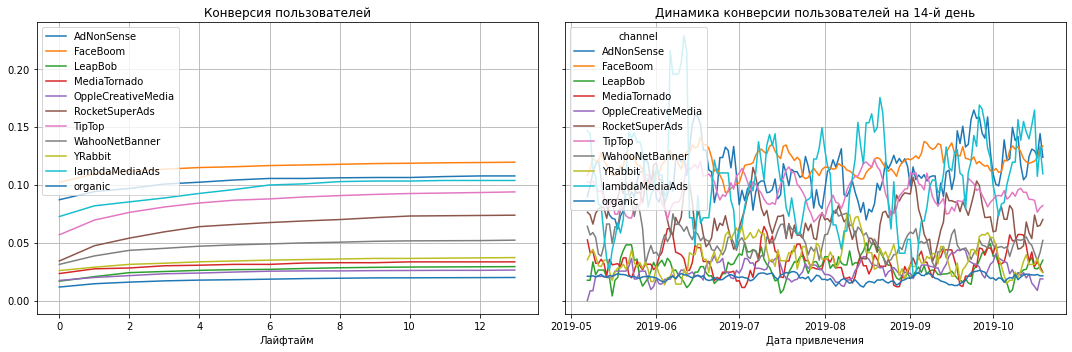

In [45]:
profiles = get_profiles(visits, orders, costs)

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon) 

Лучше всех конвертируются в покупателей пользователи, привлеченные через FaceBoom, AdNonSense, lambdaMediaAds и TipTop. Но три из них (FaceBoom, AdNonSense и TipTop), как мы помним, не окупаются из-за проблем с увеличением стоимости привлечения клиентов.

Теперь посмотрим на удержание в разбивке по каналам привлечения:

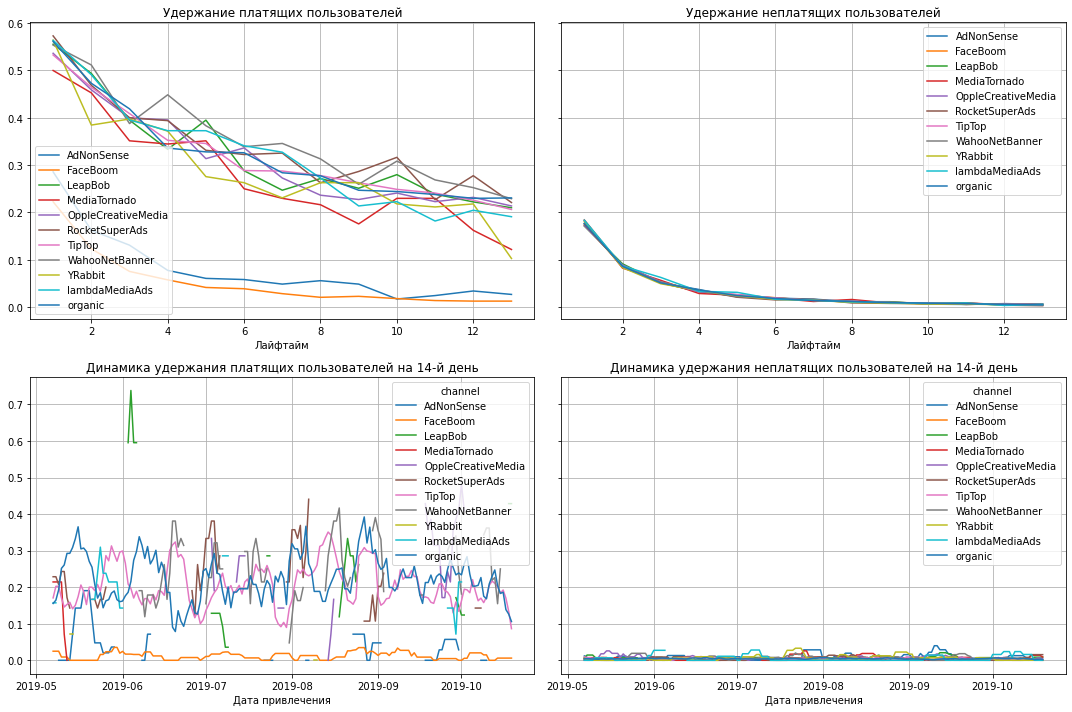

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon) 

- платящие пользователи, привлеченные через FaceBoom и AdNonSense, удерживались значительно хуже остальных;
- все неплатящие пользователи удерживались одинаково плохо вне зависимости от канала привлечения.

Посмотрим на разбивку по странам.

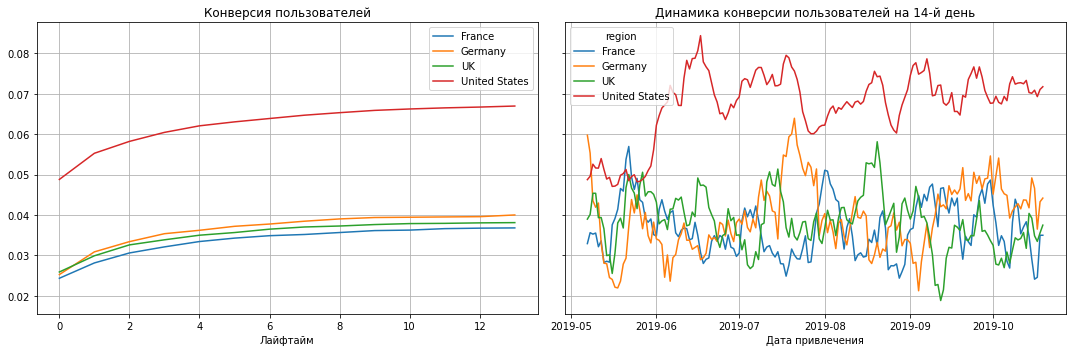

In [47]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon) 

Конверсия в США почти в два раза выше, чем в остальных странах. Причем для когорт пользователей, привлеченных в мае, конверсия для всех стран была приблизительно одинаковой - разница началась с когорт привлеченных в июне. 

Посмотрим на удержание пользователей по странам.

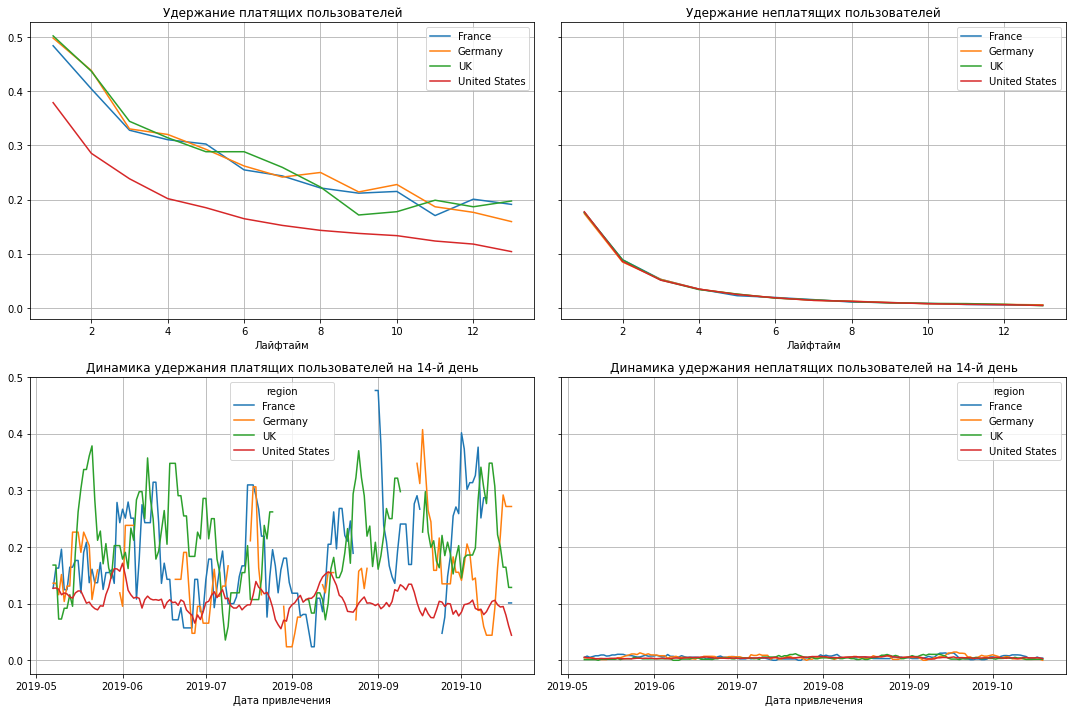

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon) 

А удерживаются платящие пользователи из США стабильно хуже пользователей из других стран. Удержание неплатящих пользователей - около нуля для любой страны.

И наконец посмотрим на разбивку по устройствам.

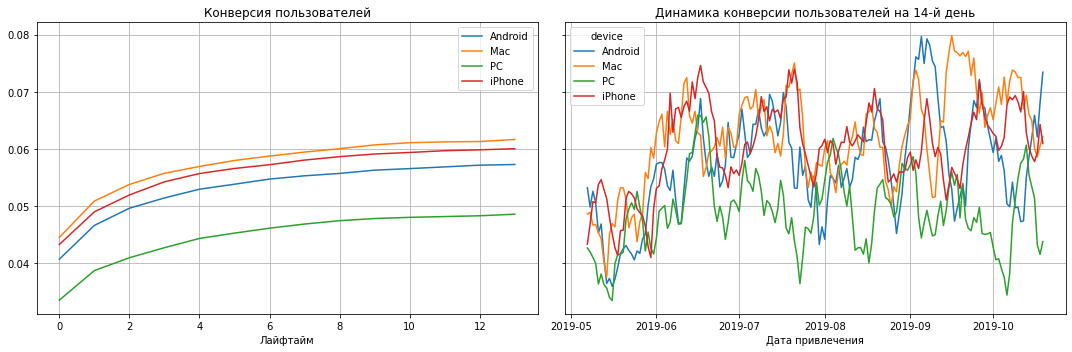

In [49]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon) 

Самая низкая конверсия у пользователей с PC, для пользователей с другими устройствами конверсия приблизительно равна. В качестве лидеров по конверсии можно выделить Mac и iPhone.

Посмотрим как менялось удержание в зависимости от устройства.

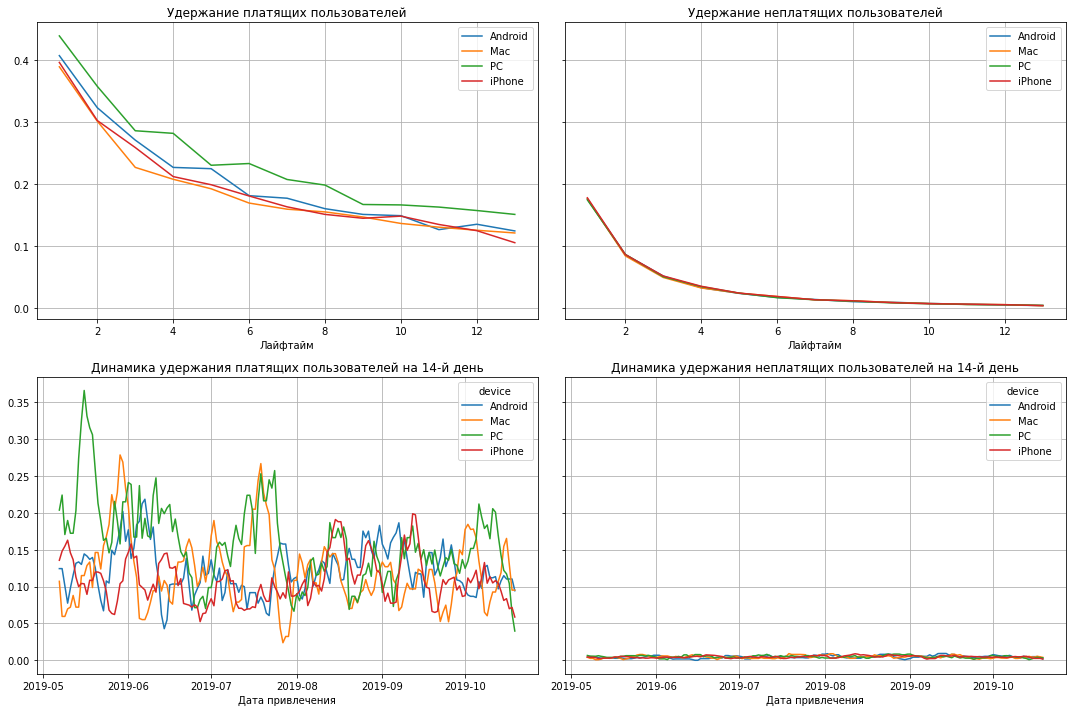

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon) 

А лучшее удержание наоборот у платящих пользователей с PC. Но в целом о взаимосвязи устройства и удержания пользователя говорить сложно, так как разница не так велика.

**Общие выводы по анализу конверсии и удержания:**

*Конверсия*:
- лучшая конверсия у пользователей, привлеченных через FaceBoom, AdNonSense, lambdaMediaAds и TipTop;
- конверсия в США почти в два раза выше, чем в остальных странах. Причем для когорт пользователей, привлеченных в мае, конверсия для всех стран была приблизительно одинаковой - разница началась с когорт привлеченных в июле.
- лидеры по конверсии - пользователи с Mac и iPhone;
- самая низкая конверсия у пользователей с PC;

*Удержание:*
- платящие пользователи, привлеченные через FaceBoom и AdNonSense, удерживались значительно хуже остальных;
- платящие пользователи из США удерживаются стабильно хуже пользователей из других стран;
- лучшее удержание наоборот у платящих пользователей с PC;
- удержание неплатящих пользователей стабильно стремится к нулю вне зависимости от разбивки по странам, каналам привлечения или устройствам.

## Выводы и рекомендации

1. Несмотря на хорошую конверсию у пользователей, привлеченных через FaceBoom и AdNonSense, удерживались они значительно хуже остальных. В итоге это привело к тому, что они стабильно не окупались.
2. Несмотря на хорошую конверсию, не окупились и пользователи, привлеченные через TipTop. Причина здесь в том, что стоимость привлечения пользователей от месяца к месяцу стабильно увеличивалась.
3. Реклама не окупилась только в США. Причем конверсия там почти два раза выше, чем в остальных странах. Причины неуспеха рекламы в США в низких показателях удержания и постоянно растущей стоимости привлечения пользователей.
4. Реклама окупается только для пользователей, использующих PC. Несмотря на то, что показатели конверсия у них самая низкая, хорошее удержание и стабильная стоимость привлечения сделали этот успех.
5. Лидеры по конверсии - пользователи с Mac и iPhone. Но постоянно растущая стоимость привлечения не дала им окупиться.

*Рекомендации:*
- обратить внимание на FaceBoom - канал привлекает очень много пользователей, которые хорошо конвертируются, но плохо удерживаются;
- обратить внимание на AdNonSense - канал находится на границе окупаемости. Пользователи, привлеченные через него, очень хорошо конвертируются, но плохо удерживаются;
- "починить" стоимость привлечения пользователей через TipTop;
- "починить" стоимость привлечения пользователей с Mac и iPhone в США, так как в основном именно в там используют эти устройства.